###### This analysis is according to long-term temperature record from 'Adelaide' station in australia the dataset is here:
###### https://reg.bom.gov.au/climate/data/acorn-sat/#tabs=Data-and-networks
###### our goal is to:
###### 1. short analysis in raw data.
###### 2. decompose tempreture data by statsmodel library.
###### 3. make model by ARIMA in resisdual component data.

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid', palette='muted')
%matplotlib inline

In [2]:
min_tmp = pd.read_csv('Adelaide-min.csv', skiprows=1)
max_tmp = pd.read_csv('Adelaide-max.csv', skiprows=1)

min_tmp.rename(columns={'Unnamed: 0':'date', 'Unnamed: 1': 'min_tmp'}, inplace=True)
max_tmp.rename(columns={'Unnamed: 0':'date', 'Unnamed: 1': 'max_tmp'}, inplace=True)

In [3]:
min_tmp.head(), max_tmp.head()

(         date  min_tmp  023000  ADELAIDE (WEST TERRACE / NGAYIRDAPIRA)
 0  1910-01-02     26.7     NaN                                     NaN
 1  1910-01-03     23.0     NaN                                     NaN
 2  1910-01-04     21.0     NaN                                     NaN
 3  1910-01-05     26.8     NaN                                     NaN
 4  1910-01-06     25.2     NaN                                     NaN,
          date  max_tmp  023000  ADELAIDE (WEST TERRACE / NGAYIRDAPIRA)
 0  1910-01-02     37.2     NaN                                     NaN
 1  1910-01-03     36.7     NaN                                     NaN
 2  1910-01-04     37.2     NaN                                     NaN
 3  1910-01-05     38.5     NaN                                     NaN
 4  1910-01-06     37.5     NaN                                     NaN)

### Data Preprocessing

In [4]:
# Take just first and second columns.

min_tmp = min_tmp.iloc[:,:2]
max_tmp = max_tmp.iloc[:,:2]
max_tmp.head()

,date,max_tmp
0,1910-01-02,37.2
1,1910-01-03,36.7
2,1910-01-04,37.2
3,1910-01-05,38.5
4,1910-01-06,37.5


In [5]:
min_tmp.shape, max_tmp.shape

((41272, 2), (41272, 2))

In [6]:
# Number of misleading values.

print("Null counts for 'min_temp' data:\n{} \n\nNull counts for 'max_temp' data:\n{}".format(min_tmp.isnull().sum(),
                                                                                        max_tmp.isnull().sum()))

Null counts for 'min_temp' data:
date         0
min_tmp    114
dtype: int64 

Null counts for 'max_temp' data:
date        0
max_tmp    66
dtype: int64


In [20]:
# Drop misaligned null values.

idx_min = np.where(min_tmp.isnull())[0]
idx_max = np.where(max_tmp.isnull())[0]


union_idx = []
for i in idx_max:
    idx = idx_min[idx_min == i]
    if idx.size > 0 :
        union_idx.append(idx[0])
        
union_idx = np.array(union_idx)


min_tmp_drop_null = min_tmp.drop(union_idx, axis=0)
max_tmp_drop_null = max_tmp.drop(union_idx, axis=0)

In [19]:
# Fill null values by forward fill method.

modified_max_tmp = max_tmp_drop_null.fillna(method='ffill')
modified_min_tmp = min_tmp_drop_null.fillna(method='ffill')

modified_max_tmp.shape, modified_min_tmp.shape

((41237, 2), (41237, 2))

In [43]:
data = pd.merge(left=modified_min_tmp, right=modified_max_tmp, on='date')
data.head()

,date,min_tmp,max_tmp
0,1910-01-02,26.7,37.2
1,1910-01-03,23.0,36.7
2,1910-01-04,21.0,37.2
3,1910-01-05,26.8,38.5
4,1910-01-06,25.2,37.5


In [45]:
data['avg_tmp'] = (data['min_tmp'] + data['max_tmp']) / 2

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data.head()

,min_tmp,max_tmp,avg_tmp
date,,,
1910-01-02,26.7,37.2,31.95
1910-01-03,23.0,36.7,29.85
1910-01-04,21.0,37.2,29.10
1910-01-05,26.8,38.5,32.65
1910-01-06,25.2,37.5,31.35


In [48]:
data = data.sort_index()
data.head()

,min_tmp,max_tmp,avg_tmp
date,,,
1910-01-02,26.7,37.2,31.95
1910-01-03,23.0,36.7,29.85
1910-01-04,21.0,37.2,29.10
1910-01-05,26.8,38.5,32.65
1910-01-06,25.2,37.5,31.35


In [64]:
def season(data):
    """
    which month has a season.
    
    data: datafarme object 
    
    """
    
    spring = ['March', 'April', 'May']
    summer = ['June', 'July', 'August']
    autumn = ['September', 'October', 'November']
    winter = ['December', 'January', 'February']    
    
    if data in spring:
        return 'spring'
    elif data in summer:
        return 'summer'
    elif data in autumn:
        return 'autumn'
    else:
        return 'winter'

In [65]:
data['month'] = data.index.month_name()
data['season'] = data['month'].apply(season) 
data.head()

,min_tmp,max_tmp,avg_tmp,month,season
date,,,,,
1910-01-02,26.7,37.2,31.95,January,winter
1910-01-03,23.0,36.7,29.85,January,winter
1910-01-04,21.0,37.2,29.10,January,winter
1910-01-05,26.8,38.5,32.65,January,winter
1910-01-06,25.2,37.5,31.35,January,winter


### Data Visualisation

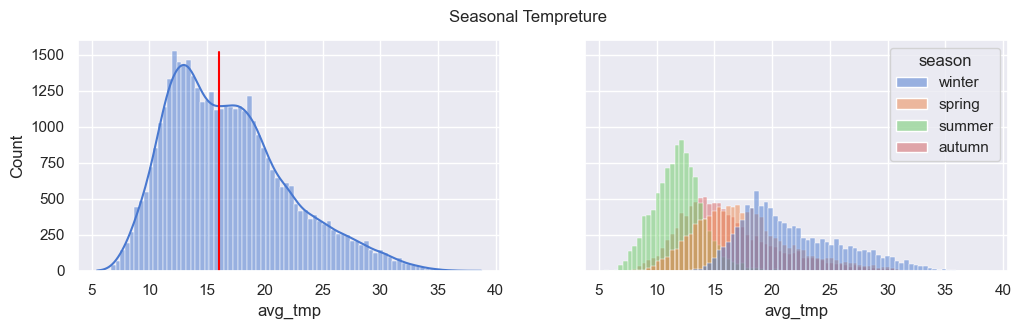

In [202]:
fig, axs = plt.subplots(1, 2,figsize=(12,3), sharey=True)

fig.suptitle('Seasonal Tempreture', fontsize=12)

sns.histplot(data=data, x='avg_tmp', hue='season', ax=axs[1])

sns.histplot(data=data, x='avg_tmp',kde=True, ax=axs[0])
axs[0].axvline(x=16, ymax=.95, c='red', linewidth=1.5)

plt.show()

## Modeling

In [246]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.api import qqplot

def AcPlot(data):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,3))
    
    plot_acf(data, lags=30, ax=ax1, auto_ylims=True)
    plot_pacf(data, lags=30, ax=ax2, auto_ylims=True, method='ywm')


def adf_test(data):
    datatest = adfuller(data, autolag = 'AIC')
    print("1. ADF : ",datatest[0])
    print("2. P-Value : ", datatest[1])
    print("3. Num Of Lags : ", datatest[2])
    print("4. Num Of Observations Used For ADF Regression:",datatest[3])
    print("5. Critical Values :")
    for key, val in datatest[4].items():
         print("\t",key, ": ", val)

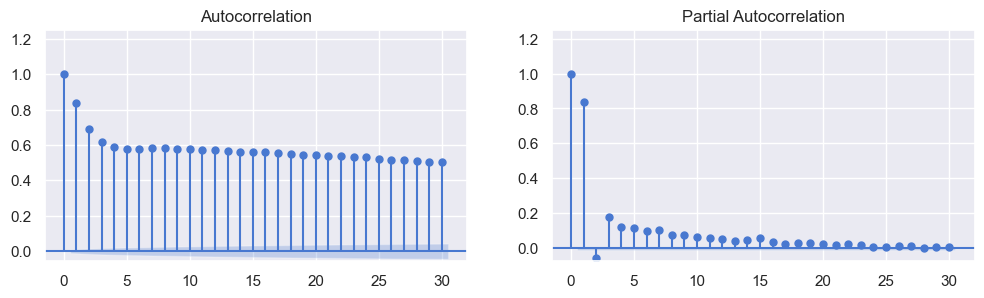

In [195]:
AcPlot(data['avg_tmp'])

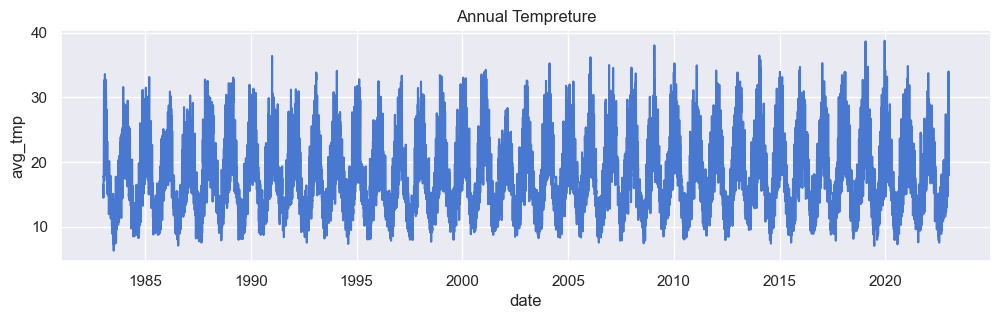

In [201]:
plt.figure(figsize=(12,3))
sns.lineplot(data['avg_tmp'][-365*40:])
plt.title('Annual Tempreture')
plt.show()

<Figure size 1200x600 with 0 Axes>

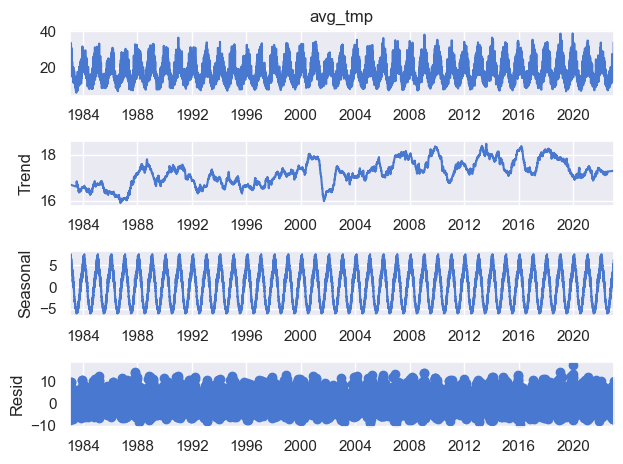

In [214]:
plt.figure(figsize=(12,6))

decompose = seasonal_decompose(data['avg_tmp'][-365*40:], model='additive', period=365, extrapolate_trend='freq')

trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid

decompose.plot()
plt.show()

In [215]:
adf_test(residual)

1. ADF :  -49.72515728718196
2. P-Value :  0.0
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression: 14596
5. Critical Values :
	 1% :  -3.430798098822551
	 5% :  -2.8617380398922596
	 10% :  -2.566875411924499


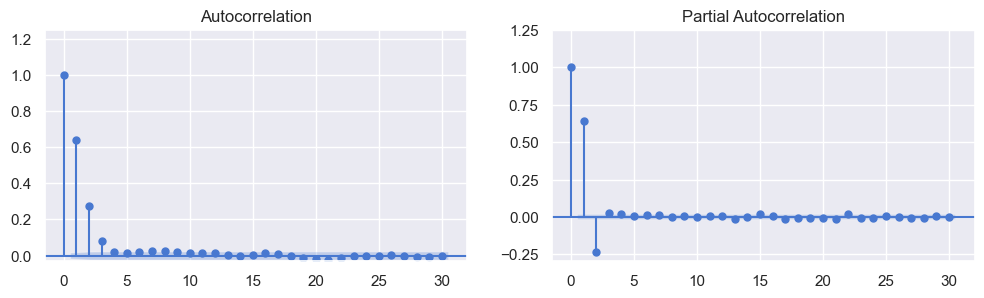

In [216]:
AcPlot(residual)

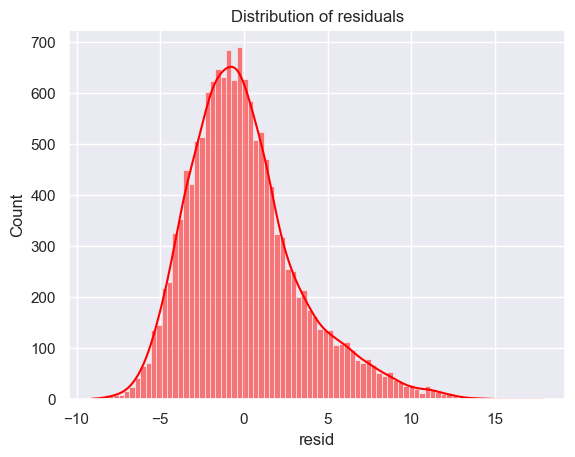

In [221]:
sns.histplot(residual, color='red', kde=True)
plt.title('Distribution of residuals')
plt.show()

In [237]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(residual, order=(2, 0, 3))
model = model.fit()
pred = model.predict()
print(model.summary())

C:\Users\Latitude 7490\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Latitude 7490\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Latitude 7490\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                14600
Model:                 ARIMA(2, 0, 3)   Log Likelihood              -34046.354
Date:                Thu, 16 Nov 2023   AIC                          68106.707
Time:                        18:34:52   BIC                          68159.829
Sample:                             0   HQIC                         68124.356
                              - 14600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0081      0.059     -0.139      0.889      -0.123       0.107
ar.L1          1.2278      0.163      7.550      0.000       0.909       1.546
ar.L2         -0.2797      0.063     -4.430      0.0

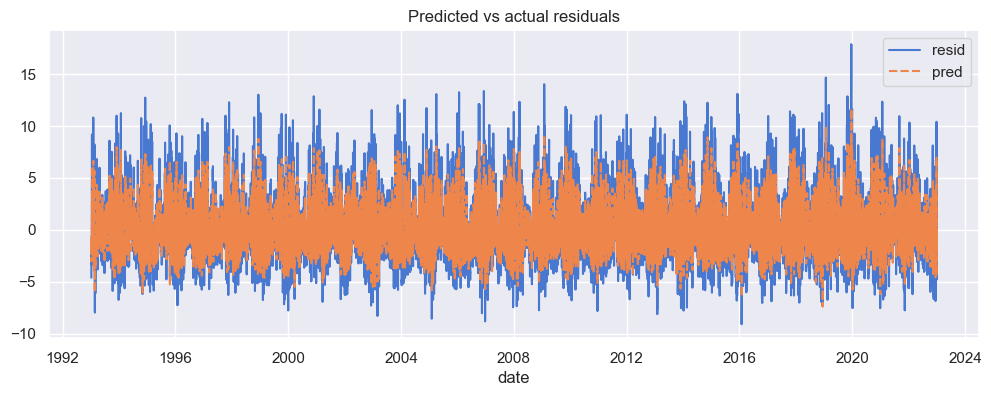

In [245]:
plot_data = pd.DataFrame(residual)
plot_data['pred'] = pred

plt.figure(figsize=(12,4))
plt.title("Predicted vs actual residuals")
sns.lineplot(plot_data[-365*30:])
plt.show()

<Figure size 800x400 with 0 Axes>

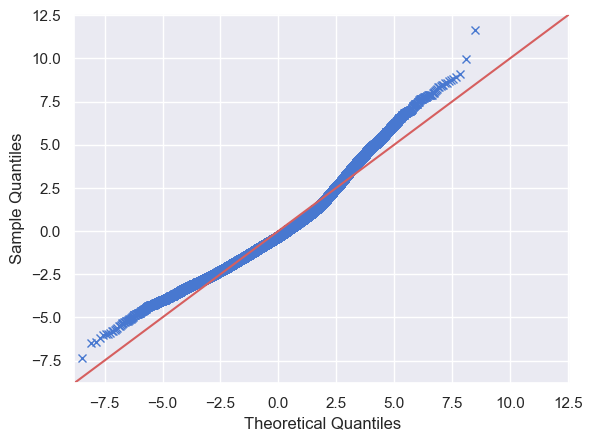

In [261]:
plt.figure(figsize=(8,4))

qqplot(pred, marker='x',line='45', scale=pred.std(), loc=0)
plt.show()